In [1]:
# Necessário importar antes do TensorFlow para reproduzir os resultados das redes neurais artificiais - ANN
import os

os.environ['PYTHONHASHSEED']=str(1)

# 1 Bibliotecas

In [2]:
# Importação das bibliotecas utilizadas no trabalho
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel,ExpSineSquared,Matern, RationalQuadratic
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,MaxAbsScaler,RobustScaler


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import tensorflow as tf
import random

In [3]:
# Função para chamar antes de rodar as ANNs a fim de proporcionar uma reprodutibilidade do modelo.
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

# Gerando dados aleatórios
reset_random_seeds()

# 2 Banco de Dados 


Para que o código funcione sem que seja necessário alterá-lo, é necessário de que a coluna com os dados de resistência esteja com o nome de "Resistência" antes de rodar a celula de importar abaixo.

In [4]:
# Importando o DataSet
df_concreto = pd.read_excel("Banco_28.xlsx") # ALTERAR AQUI O NOME DO ARQUIVO

In [5]:
df_concreto = df_concreto.rename(columns={'Resistencia':'Resistência'})

In [6]:
df_concreto.head()

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Resistência
0,617.0,0.0,524.45,542.96,445.7825,0.30,185.10,52.513966,1.1,0.0,0.0,0.0,28,52.84
1,617.0,0.0,1048.90,542.96,0.0000,0.30,185.10,52.513966,1.1,0.0,0.0,0.0,28,56.02
2,369.0,0.0,479.70,560.88,623.6100,0.52,191.88,49.218750,0.0,0.0,0.0,0.0,28,19.61
3,369.0,0.0,959.40,560.88,0.0000,0.52,191.88,49.218750,0.0,0.0,0.0,0.0,28,23.55
4,265.0,0.0,614.80,866.55,1426.3360,0.80,212.00,47.923681,0.0,0.0,0.0,0.0,28,11.60


In [7]:
df_concreto.shape

(146, 14)

# 3 Machine Learning

## 3.1 Preparação

Primeiro vamos criar um DataFrame para armazenar o resultado de cada modelo.

In [8]:
colunas = ['MODEL','MAE','RMSE', 'MSE', 'R2','MAE_MAX','MAE_MIN']
Metrics = pd.DataFrame(columns = colunas)

Vamos também já organizar o banco de dados e o cross validation para todos os modelos utilizarem o mesmo.

In [9]:
X = df_concreto.drop(['Resistência','Agua/cimento','Teor_argamassa','Idade'], axis=1)
y = df_concreto['Resistência']
X.shape

(146, 10)

Definindo as configurações do KFold:

In [10]:
kf = KFold(10, shuffle=True, random_state=451)

Criando a Matriz de Correlação:

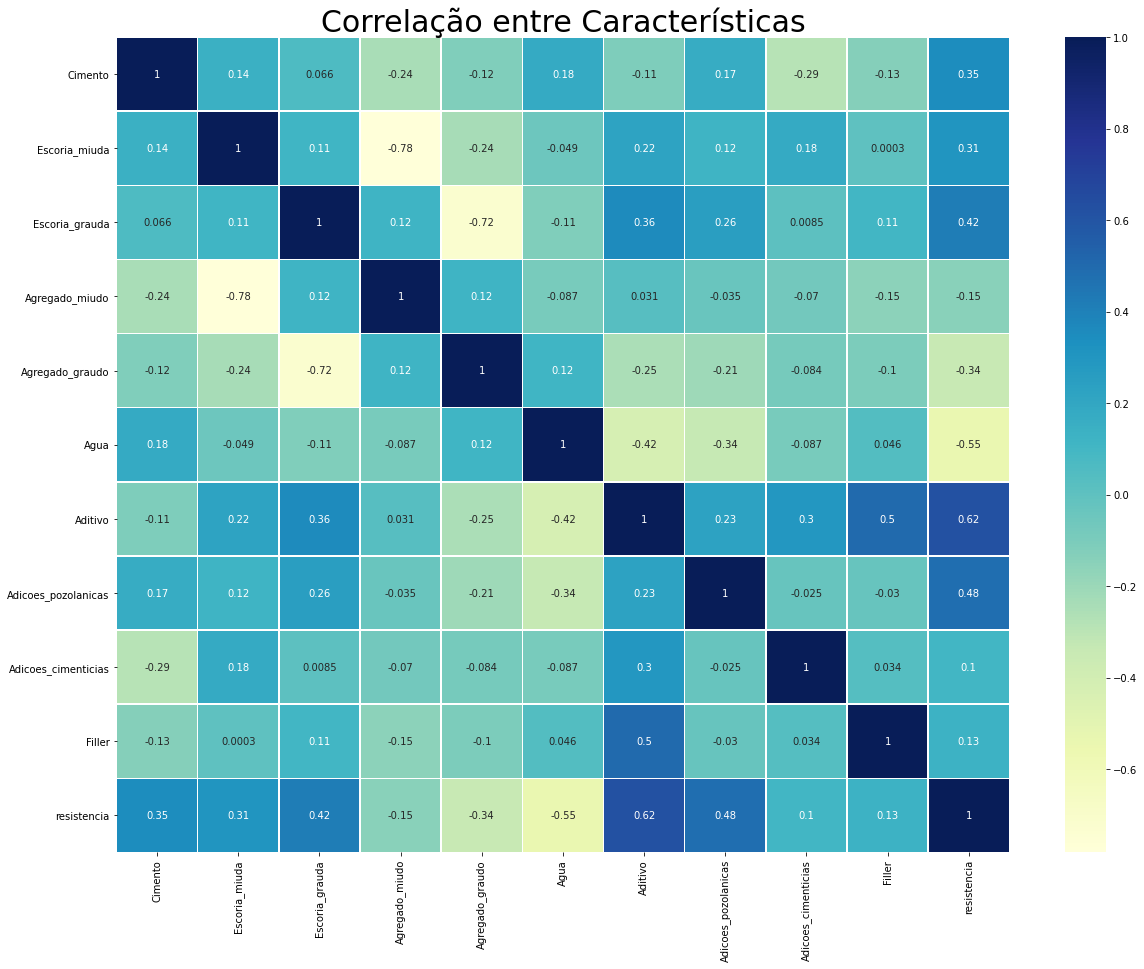

In [11]:
test_corr = X.copy()
test_corr['resistencia'] = y

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(test_corr.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Correlação entre Características', fontsize = 30)
plt.show()

## 3.2 Modelos

### 3.2.1 Processo Gaussiano de Regressão (GPR)

In [12]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []
# -------------------

# Dataframe criado com o intuito de analisar cada resultado real e predito.
df_analise_gpr = pd.DataFrame(columns=[['real','predito']])
# ------------------

# Criação de um laço "for" para percorrer cada fold definido
for linhas_treino, linhas_valid in kf.split(X):    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)      

    # Modelo: definição do Kernel e treinamento
    kernel = ConstantKernel() * RationalQuadratic()
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1.5,random_state=0).fit(X_treino, y_treino)
    
    # Predições do modelo
    pred_gpr = gpr.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()
    df_pred['real'] = y_valid
    df_pred['predito'] = pred_gpr
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_gpr.shape[0] == 0:
        df_analise_gpr = df_pred
    else:
        df_analise_gpr = pd.concat([df_analise_gpr, df_pred])
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_gpr)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_gpr, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_gpr, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_gpr)
    R2.append(R2_aux)

In [13]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_gpr = df_concreto.copy()
df_an_gpr = df_an_gpr.rename(columns={'Resistência': 'Real','EscóriadeAltoForno': 'Escoria'})

df_an_gpr['predito'] = df_analise_gpr['predito']
df_an_gpr['mae'] = abs(df_an_gpr['Real']-df_an_gpr['predito'])

MAE_MAX = df_an_gpr['mae'].max()
MAE_MIN= df_an_gpr['mae'].min()

In [14]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
gprmetrics = ['GPR', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2),MAE_MAX,MAE_MIN]
Metrics.loc[len(Metrics)] = gprmetrics

### 3.2.2 Redes Neurais Artificiais (ANN)

In [15]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []

# Dataframe criado com o intuito de analisar cada resultado real e predito.
df_analise_ann = pd.DataFrame(columns=[['real','predito']])

# Criação de um laço "for" para percorrer cada fold definido 
for linhas_treino, linhas_valid in kf.split(X):
    
    # Função para obter resultados reprodutíveis 
    reset_random_seeds()

    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)
    
    # Definindo o EarlyStopping, a fim de que o modelo pare ao registrar que as predições não estão melhorando
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.02, # o valor de melhora desejado
        patience=25, # a quantidade de vezes que ele deve rodar sem obter a melhora acima para parar o algoritmo
        restore_best_weights=True)
    
    # Definição do modelo e treinamento
    model = keras.Sequential([
        layers.BatchNormalization(), # Normalização dos dados
        layers.Dense(256, activation='relu', input_shape=[X.shape[1]]),# Define-se a camada com 256 neurônios, função de ativação "relu" e input de acordo com a quantidade de variáveis de entrada
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1), #Saída de apenas uma variável
    ])
    
    
    model.compile(
        optimizer='sgd', # Define-se o tipo de otimizador utilizado
        loss='mae', # Define-se a "loss function"
        metrics=['mae','mse'],
    )
    history = model.fit(
        X_treino, y_treino, # Dados de treino
        validation_data=(X_valid, y_valid), # Dados de teste
        batch_size=45, #Define-se a quantidade de lotes
        epochs=150, #Define-se a quantidade de épocas
        verbose=0,
        callbacks=[early_stopping],
    
    )
    
    # Predições do modelo
    ann_pred = model.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()    
    df_pred['real'] = y_valid
    df_pred['predito'] = ann_pred    
    pred_ann = df_pred['predito']
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_ann.shape[0] == 0:
        df_analise_ann = df_pred
    else:
        df_analise_ann = pd.concat([df_analise_ann, df_pred])
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_ann)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_ann, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_ann, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_ann)
    R2.append(R2_aux)
    


In [16]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_ann = df_concreto.copy()
df_an_ann = df_an_ann.rename(columns={'Resistência': 'Real'})

df_an_ann['predito'] = df_analise_ann['predito']
df_an_ann['mae'] = abs(df_an_ann['Real']- df_an_ann['predito'])

MAE_MAX = df_an_ann['mae'].max()
MAE_MIN= df_an_ann['mae'].min()

In [17]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
annmetrics = ['ANN', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2), MAE_MAX, MAE_MIN]
Metrics.loc[len(Metrics)] = annmetrics

### 3.2.3 Extreme Gradient Boosting (XGBoost)

In [18]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []


df_analise_xgboost = pd.DataFrame(columns=[['real','predito']])
for linhas_treino, linhas_valid in kf.split(X):    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
    
    # Define-se o modelo
    xgbc = xgb.XGBRegressor(colsample_bytree= 0.5333820701805849, #0-1 
                            learning_rate= 0.12663989471251058, #0-1
                            max_depth= 9, #1-10
                            min_child_weight= 3.2838398180702932, #0-10
                            subsample= 0.2938445453291092) #0-1
    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)
    
    # Treina-se o modelo
    xgbc.fit(X_treino, y_treino)
    
    # Previsões do modelo
    pred_gpr = xgbc.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()
    df_pred['real'] = y_valid
    df_pred['predito'] = pred_gpr
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_xgboost.shape[0] == 0:
        df_analise_xgboost = df_pred
    else:
        df_analise_xgboost = pd.concat([df_analise_xgboost, df_pred])
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_gpr)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_gpr, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_gpr, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_gpr)
    R2.append(R2_aux)

In [19]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_xgboost = df_concreto.copy()
df_an_xgboost = df_an_xgboost.rename(columns={'Resistência': 'Real','EscóriadeAltoForno': 'Escoria'})

df_an_xgboost['predito'] = df_analise_xgboost['predito']
df_an_xgboost['mae'] = abs(df_an_xgboost['Real']-df_an_xgboost['predito'])

MAE_MAX = df_an_xgboost['mae'].max()
MAE_MIN = df_an_xgboost['mae'].min()

In [20]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
gprmetrics = ['XGBoost', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2), MAE_MAX, MAE_MIN]
Metrics.loc[len(Metrics)] = gprmetrics

### 3.2.4 Support Vector Regression (SVR)

In [21]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []

df_analise_svr = pd.DataFrame(columns=[['real','predito']])
for linhas_treino, linhas_valid in kf.split(X):    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
    
    # Definição do modelo
    svr_model = SVR(kernel='rbf',C = 205.66079785025673, gamma = 0.012257611393695286)
    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)
    
    # Treina-se o modelo
    svr_model.fit(X_treino, y_treino)
    
    # Predições do modelo
    pred_svr = svr_model.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()
    df_pred['real'] = y_valid
    df_pred['predito'] = pred_svr
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_svr.shape[0] == 0:
        df_analise_svr = df_pred
    else:
        df_analise_svr = pd.concat([df_analise_svr, df_pred])
            
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_svr)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_svr, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_svr, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_svr)
    R2.append(R2_aux)

In [22]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_svr = df_concreto.copy()
df_an_svr = df_an_svr.rename(columns={'Resistência': 'Real'})

df_an_svr['predito'] = df_analise_svr['predito']
df_an_svr['mae'] = abs(df_an_svr['Real']-df_an_svr['predito'])

MAE_MAX = df_an_svr['mae'].max()
MAE_MIN = df_an_svr['mae'].min()

In [23]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
svrmetrics = ['SVR', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2), MAE_MAX, MAE_MIN]
Metrics.loc[len(Metrics)] = svrmetrics

## 3.3 Resultados

In [24]:
Metrics

,MODEL,MAE,RMSE,MSE,R2,MAE_MAX,MAE_MIN
0,GPR,4.980380,7.091426,52.175310,0.679975,27.028486,0.009390
1,ANN,4.532894,6.380151,44.252385,0.791483,25.733108,0.076065
2,XGBoost,5.023212,6.764458,48.365214,0.734926,27.954240,0.064312
3,SVR,5.507196,7.438388,60.030769,0.702132,26.591703,0.006240


## 3.4 Piores Resultados

In [25]:
Piores_ANN = df_an_ann.sort_values(by='mae',ascending=False).head(10)

In [26]:
Piores_ANN

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Real,predito,mae
86,416.000000,0.000000,572.000000,624.000000,624.0,0.399038,166.000000,45.454545,0.4800,0.0,0.0,0.0,28,61.700000,35.966892,25.733108
35,424.584262,999.811021,0.000000,0.000000,0.0,0.400000,168.000000,93.746158,0.3714,0.0,0.0,0.0,28,60.700000,35.678146,25.021854
38,346.000000,0.000000,1331.000000,865.000000,0.0,0.400000,139.000000,47.639654,3.4682,0.0,0.0,0.0,28,47.241379,67.458839,20.217460
18,354.321701,938.952508,1055.878669,0.000000,0.0,0.600000,212.593021,91.708543,0.0000,0.0,0.0,0.0,28,43.000000,24.204445,18.795555
79,500.000000,0.000000,1452.000000,506.000000,0.0,0.300000,150.000000,40.927583,1.0000,0.0,0.0,0.0,28,81.600000,65.417969,16.182031
69,345.000000,516.000000,0.000000,172.000000,1122.0,0.579710,200.000000,63.026236,0.0000,0.0,0.0,0.0,28,9.370079,25.472923,16.102845
34,425.067261,0.000000,1449.266826,730.690622,0.0,0.400000,168.000000,44.366484,0.3095,0.0,0.0,0.0,28,40.500000,55.486233,14.986233
70,345.000000,688.000000,1122.000000,0.000000,0.0,0.579710,200.000000,70.415815,0.0000,0.0,0.0,0.0,28,13.779528,28.655874,14.876347
109,460.000000,0.000000,875.000000,830.000000,390.0,0.290000,133.000000,50.489237,1.5217,0.0,0.0,0.0,28,88.534483,74.321503,14.212980
77,526.000000,330.000000,988.000000,330.000000,0.0,0.380228,200.000000,64.316703,0.0000,0.0,0.0,0.0,28,20.551181,34.637726,14.086545


In [27]:
Piores_SVR = df_an_svr.sort_values(by='mae',ascending=False).head(10)

In [28]:
Piores_SVR.to_excel("Piores_SVR.xls")

In [29]:
Piores_SVR

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Real,predito,mae
35,424.584262,999.811021,0.000000,0.0,0.0,0.400000,168.000000,93.746158,0.3714,0.0,0.0,0.0,28,60.700000,34.108297,26.591703
38,346.000000,0.000000,1331.000000,865.0,0.0,0.400000,139.000000,47.639654,3.4682,0.0,0.0,0.0,28,47.241379,73.198696,25.957317
111,54.500000,1330.500000,785.700000,0.0,0.0,2.935780,160.000000,164.841704,3.0090,0.0,435.9,54.5,28,56.220472,32.783310,23.437163
86,416.000000,0.000000,572.000000,624.0,624.0,0.399038,166.000000,45.454545,0.4800,0.0,0.0,0.0,28,61.700000,40.278466,21.421534
109,460.000000,0.000000,875.000000,830.0,390.0,0.290000,133.000000,50.489237,1.5217,0.0,0.0,0.0,28,88.534483,67.766325,20.768158
77,526.000000,330.000000,988.000000,330.0,0.0,0.380228,200.000000,64.316703,0.0000,0.0,0.0,0.0,28,20.551181,39.901826,19.350645
79,500.000000,0.000000,1452.000000,506.0,0.0,0.300000,150.000000,40.927583,1.0000,0.0,0.0,0.0,28,81.600000,62.780187,18.819813
18,354.321701,938.952508,1055.878669,0.0,0.0,0.600000,212.593021,91.708543,0.0000,0.0,0.0,0.0,28,43.000000,25.742647,17.257353
66,426.000000,660.000000,431.000000,0.0,646.0,0.469484,200.000000,72.255489,0.0000,0.0,0.0,0.0,28,15.984252,31.592843,15.608591
37,375.000000,1456.270000,1344.260000,0.0,0.0,0.420000,158.000000,106.515012,3.0000,0.0,0.0,0.0,28,47.637795,63.040480,15.402685


In [30]:
Piores_XGBoost = df_an_xgboost.sort_values(by='mae',ascending=False).head(10)

In [31]:
Piores_XGBoost.to_excel("Piores_XGBoost.xls")

In [32]:
Piores_XGBoost

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Real,predito,mae
79,500.000000,0.000000,1452.000000,506.0,0.0,0.300000,150.000000,40.927583,1.0000,0.0,0.0,0.0,28,81.600000,53.645760,27.954240
18,354.321701,938.952508,1055.878669,0.0,0.0,0.600000,212.593021,91.708543,0.0000,0.0,0.0,0.0,28,43.000000,22.489986,20.510014
35,424.584262,999.811021,0.000000,0.0,0.0,0.400000,168.000000,93.746158,0.3714,0.0,0.0,0.0,28,60.700000,40.206760,20.493240
109,460.000000,0.000000,875.000000,830.0,390.0,0.290000,133.000000,50.489237,1.5217,0.0,0.0,0.0,28,88.534483,70.377464,18.157018
95,300.000000,293.000000,1350.000000,0.0,0.0,0.650000,195.000000,35.939394,3.6000,0.0,0.0,815.0,28,57.422680,41.253292,16.169388
77,526.000000,330.000000,988.000000,330.0,0.0,0.380228,200.000000,64.316703,0.0000,0.0,0.0,0.0,28,20.551181,35.718040,15.166859
86,416.000000,0.000000,572.000000,624.0,624.0,0.399038,166.000000,45.454545,0.4800,0.0,0.0,0.0,28,61.700000,46.562569,15.137431
63,625.000000,0.000000,699.000000,562.0,300.0,0.320000,200.000000,54.300091,0.0000,0.0,0.0,0.0,28,47.716535,33.013664,14.702871
70,345.000000,688.000000,1122.000000,0.0,0.0,0.579710,200.000000,70.415815,0.0000,0.0,0.0,0.0,28,13.779528,28.373539,14.594011
94,300.000000,265.000000,1208.000000,0.0,0.0,0.690000,207.000000,37.466844,3.6000,0.0,0.0,815.0,28,56.701031,42.311043,14.389988


In [33]:
Piores_GPR = df_an_gpr.sort_values(by='mae',ascending=False).head(10)

In [34]:
Piores_GPR.to_excel("Piores_GPR.xls")

In [35]:
Piores_GPR

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Real,predito,mae
18,354.321701,938.952508,1055.878669,0.000000,0.0,0.600000,212.593021,91.708543,0.0000,0.0,0.0,0.0,28,43.000000,15.971514,27.028486
86,416.000000,0.000000,572.000000,624.000000,624.0,0.399038,166.000000,45.454545,0.4800,0.0,0.0,0.0,28,61.700000,35.985298,25.714702
70,345.000000,688.000000,1122.000000,0.000000,0.0,0.579710,200.000000,70.415815,0.0000,0.0,0.0,0.0,28,13.779528,38.656241,24.876713
35,424.584262,999.811021,0.000000,0.000000,0.0,0.400000,168.000000,93.746158,0.3714,0.0,0.0,0.0,28,60.700000,37.448473,23.251527
79,500.000000,0.000000,1452.000000,506.000000,0.0,0.300000,150.000000,40.927583,1.0000,0.0,0.0,0.0,28,81.600000,62.986978,18.613022
39,354.000000,0.000000,1262.000000,820.000000,0.0,0.550000,195.000000,48.193760,1.3842,0.0,0.0,0.0,28,32.327586,50.705710,18.378124
109,460.000000,0.000000,875.000000,830.000000,390.0,0.290000,133.000000,50.489237,1.5217,0.0,0.0,0.0,28,88.534483,70.904138,17.630345
77,526.000000,330.000000,988.000000,330.000000,0.0,0.380228,200.000000,64.316703,0.0000,0.0,0.0,0.0,28,20.551181,36.258413,15.707232
34,425.067261,0.000000,1449.266826,730.690622,0.0,0.400000,168.000000,44.366484,0.3095,0.0,0.0,0.0,28,40.500000,54.659535,14.159535
38,346.000000,0.000000,1331.000000,865.000000,0.0,0.400000,139.000000,47.639654,3.4682,0.0,0.0,0.0,28,47.241379,59.784632,12.543252


## 3.5 Interseção dos Piores Resultados

In [36]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

index_intersection = intersection(Piores_ANN.index, Piores_GPR.index)
index_intersection = intersection(index_intersection, Piores_XGBoost.index)
index_intersection = intersection(index_intersection, Piores_SVR.index)

In [37]:
#Criar um DataSet com todos as predições e erros
df_analise = df_concreto.copy()
df_analise['Predito_GPR'] = df_analise_gpr['predito']
df_analise['Predito_ANN'] = df_analise_ann['predito']
df_analise['Predito_XGBoost'] = df_analise_xgboost['predito']
df_analise['Predito_SVR'] = df_analise_svr['predito']

In [38]:
df_analise.iloc[index_intersection]

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Resistência,Predito_GPR,Predito_ANN,Predito_XGBoost,Predito_SVR
86,416.000000,0.000000,572.000000,624.0,624.0,0.399038,166.000000,45.454545,0.4800,0.0,0.0,0.0,28,61.700000,35.985298,35.966892,46.562569,40.278466
35,424.584262,999.811021,0.000000,0.0,0.0,0.400000,168.000000,93.746158,0.3714,0.0,0.0,0.0,28,60.700000,37.448473,35.678146,40.206760,34.108297
18,354.321701,938.952508,1055.878669,0.0,0.0,0.600000,212.593021,91.708543,0.0000,0.0,0.0,0.0,28,43.000000,15.971514,24.204445,22.489986,25.742647
79,500.000000,0.000000,1452.000000,506.0,0.0,0.300000,150.000000,40.927583,1.0000,0.0,0.0,0.0,28,81.600000,62.986978,65.417969,53.645760,62.780187
109,460.000000,0.000000,875.000000,830.0,390.0,0.290000,133.000000,50.489237,1.5217,0.0,0.0,0.0,28,88.534483,70.904138,74.321503,70.377464,67.766325
77,526.000000,330.000000,988.000000,330.0,0.0,0.380228,200.000000,64.316703,0.0000,0.0,0.0,0.0,28,20.551181,36.258413,34.637726,35.718040,39.901826


# 4 Validação

Espaço para testar o desempenho do modelo em outro banco de dados buscado na literatura.

In [39]:
# Importando o DataSet para validação
df_concreto_novo = pd.read_excel('DF_Laboratorio_Adap.xlsx')

In [40]:
df_concreto_novo = df_concreto_novo.rename(columns = {'Resistencia':'Resistência'})

In [41]:
df_concreto_novo.head()

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Resistência
0,310,1376.40,1171.86,0,0,0.615000,190.65,54.031366,0.25,0,0.00,0,28,22.190476
1,310,1361.16,1161.31,0,0,0.651032,201.82,53.979639,0.70,0,15.51,0,28,23.492063
2,310,1345.25,1150.26,0,0,0.667710,206.99,53.925280,0.70,0,23.86,0,28,29.841270
3,310,1330.80,1140.21,0,0,0.688581,213.46,53.875187,0.30,0,34.29,0,28,22.349206
4,310,1281.23,1105.77,0,0,0.739032,229.10,53.694724,0.25,0,60.00,0,28,19.746032


In [42]:
df_concreto_novo.shape

(20, 14)

Primeiro vamos criar um DataSet para armazenar o resultado de cada modelo.

In [43]:
colunas = ['MODEL','MAE','RMSE', 'MSE', 'R2','MAE_MAX','MAE_MIN']
Metrics_valid = pd.DataFrame(columns = colunas)

Vamos também já organizar o treino como o dataset antigo e o teste como o novo

In [44]:
X_treino = df_concreto.drop(['Resistência','Agua/cimento','Teor_argamassa','Idade'], axis=1)
X_treino = scaler.fit_transform(X_treino)
y_treino = df_concreto['Resistência']

X_valid = df_concreto_novo.drop(['Resistência','Agua/cimento','Teor_argamassa','Idade'], axis=1)
X_valid = scaler.fit_transform(X_valid)
y_valid = df_concreto_novo['Resistência']

## 4.2. Modelos

Essa parte vai ser igual a 3.2. Treinamento e predições dos modelos.

### 4.2.1. Processo Gaussiano de Regressão (GPR)

In [45]:
# Modelo: definição do Kernel e treinamento
kernel = ConstantKernel() * RationalQuadratic()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_treino, y_treino)

# Predições do modelo
pred_gpr = gpr.predict(X_valid)

# Armazenamento do valor obtido na predição
df_analise_gpr = pd.DataFrame()
df_analise_gpr['real'] = y_valid
df_analise_gpr['predito'] = pred_gpr

# Cálculo das métricas do modelo
MAE = mean_absolute_error(y_valid, pred_gpr)          
RMSE = mean_squared_error(y_valid, pred_gpr, squared=False)
MSE = mean_squared_error(y_valid, pred_gpr, squared=True)
R2 = r2_score(y_valid, pred_gpr)

In [46]:
# Obtêm-se os valores máximo e mínimo do MAE
df_analise_gpr['mae'] = abs(df_analise_gpr['real']-df_analise_gpr['predito'])

MAE_MAX = df_analise_gpr['mae'].max()
MAE_MIN= df_analise_gpr['mae'].min()

Metrics_valid=Metrics_valid.append({'MODEL': 'GPR','MAE': MAE,'RMSE': RMSE, 'MSE': MSE, 'R2': R2,
                        'MAE_MAX': MAE_MAX,'MAE_MIN': MAE_MIN} , ignore_index=True)

### 4.2.2. Redes Neurais Artificiais (ANN)

In [47]:
#Função para obter resultados reprodutíveis 
reset_random_seeds()

# Definindo o EarlyStopping, a fim de que o modelo pare ao registrar que as predições não estão melhorando
early_stopping = callbacks.EarlyStopping(
    min_delta=0.02,
    patience=25,
    restore_best_weights=True)

# Definição do modelo e treinamento
model = keras.Sequential([
    layers.BatchNormalization(), # Normalização dos dados
    layers.Dense(256, activation='relu', input_shape=[X.shape[1]]), # Define-se a camada com 256 neurônios, função de ativação "relu" e input de acordo com a quantidade de variáveis de entrada
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1), # Saída de apenas uma variável
])


model.compile(
    optimizer='sgd', # Define-se o tipo de otimizador utilizado
    loss='mae', # Define-se a "loss function"
    metrics=['mae','mse'],
)
history = model.fit(
    X_treino, y_treino, # Dados de treino
    validation_data=(X_valid, y_valid), # Dados de teste
    batch_size=45, #Define-se a quantidade de lotes
    epochs=150, #Define-se a quantidade de épocas
    verbose=0,
    callbacks=[early_stopping],

)

 # Predições do modelo
ann_pred = model.predict(X_valid)

# Armazenamento do valor obtido na predição
df_analise_ann = pd.DataFrame()    
df_analise_ann['real'] = y_valid
df_analise_ann['predito'] = ann_pred    
pred_ann = df_analise_ann['predito']

# Cálculo das métricas do modelo
MAE = mean_absolute_error(y_valid, pred_ann)          
RMSE = mean_squared_error(y_valid, pred_ann, squared=False) 
MSE = mean_squared_error(y_valid, pred_ann, squared=True)
R2 = r2_score(y_valid, pred_ann)

In [48]:
# Obtêm-se os valores máximo e mínimo do MAE
df_analise_ann['mae'] = abs(df_analise_ann['real']-df_analise_ann['predito'])

MAE_MAX = df_analise_ann['mae'].max()
MAE_MIN= df_analise_ann['mae'].min()

Metrics_valid=Metrics_valid.append({'MODEL': 'ANN','MAE': MAE,'RMSE': RMSE, 'MSE': MSE, 'R2': R2,
                        'MAE_MAX': MAE_MAX,'MAE_MIN': MAE_MIN} , ignore_index=True)

### 4.2.3. Extreme Gradient Boosting (XGBoost)

In [49]:
# Definição do modelo
xgbc = xgb.XGBRegressor(colsample_bytree= 0.5333820701805849, 
                            learning_rate= 0.12663989471251058, 
                            max_depth= 9, 
                            min_child_weight= 3.2838398180702932, 
                            subsample= 0.2938445453291092)

# Treina-se o modelo
xgbc.fit(X_treino, y_treino)

# Predições do modelo
pred_gpr = xgbc.predict(X_valid)

# Armazenamento do valor obtido na predição
df_analise_xgboost = pd.DataFrame()
df_analise_xgboost['real'] = y_valid
df_analise_xgboost['predito'] = pred_gpr

# Cálculo das métricas do modelo
MAE = mean_absolute_error(y_valid, pred_gpr)          
RMSE = mean_squared_error(y_valid, pred_gpr, squared=False)
MSE = mean_squared_error(y_valid, pred_gpr, squared=True)
R2 = r2_score(y_valid, pred_gpr)

In [50]:
# Obtêm-se os valores máximo e mínimo do MAE
df_analise_xgboost['mae'] = abs(df_analise_xgboost['real']-df_analise_xgboost['predito'])

MAE_MAX = df_analise_xgboost['mae'].max()
MAE_MIN= df_analise_xgboost['mae'].min()

Metrics_valid=Metrics_valid.append({'MODEL': 'XGBoost','MAE': MAE,'RMSE': RMSE, 'MSE': MSE, 'R2': R2,
                        'MAE_MAX': MAE_MAX,'MAE_MIN': MAE_MIN} , ignore_index=True)

### 4.2.4. Support Vector Regression (SVR)

In [51]:
# Definição do modelo
svr_model = SVR(kernel='rbf',C = 205.66079785025673, gamma = 0.012257611393695286)

# Treina-se o modelo
svr_model.fit(X_treino, y_treino)

# Predições do modelo
pred_svr = svr_model.predict(X_valid)

 # Armazenamento do valor obtido na predição
df_analise_svr = pd.DataFrame()
df_analise_svr['real'] = y_valid
df_analise_svr['predito'] = pred_svr

# Cálculo das métricas do modelo
MAE = mean_absolute_error(y_valid, pred_svr)          
RMSE = mean_squared_error(y_valid, pred_svr, squared=False)
MSE = mean_squared_error(y_valid, pred_svr, squared=True)
R2 = r2_score(y_valid, pred_svr)

In [52]:
# Obtêm-se os valores máximo e mínimo do MAE
df_analise_svr['mae'] = abs(df_analise_svr['real']-df_analise_svr['predito'])

MAE_MAX = df_analise_svr['mae'].max()
MAE_MIN= df_analise_svr['mae'].min()

Metrics_valid=Metrics_valid.append({'MODEL': 'SVR','MAE': MAE,'RMSE': RMSE, 'MSE': MSE, 'R2': R2,
                        'MAE_MAX': MAE_MAX,'MAE_MIN': MAE_MIN} , ignore_index=True)

## 4.3. Resultados

In [53]:
Metrics_valid

,MODEL,MAE,RMSE,MSE,R2,MAE_MAX,MAE_MIN
0,GPR,13.980957,15.796930,249.543012,-2.560784,31.068022,2.536241
1,ANN,5.679867,6.913884,47.801795,0.317906,15.230921,0.196239
2,XGBoost,21.122050,23.371744,546.238404,-6.794395,41.265261,5.347275
3,SVR,13.170988,16.235055,263.577008,-2.761038,35.612627,1.259353
